In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import xarray as xr

import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from datetime import datetime
import pandas as pd

import scipy.spatial as spatial
import itertools

from datetime import datetime

import open3d as o3d

from pyntcloud import PyntCloud

from skimage.color import rgb2hsv, hsv2rgb

from lshashpy3 import LSHash
from tqdm import notebook
import random

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import open3d as o3d
from open3d.web_visualizer import draw
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=100, origin=[1, 1, 1])
# draw([mesh_frame],)

[Open3D INFO] Resetting default logger to print to terminal.


In [5]:
sys.path.append('../')
sys.path.append('../d2geo/attributes/')
from PointCloudSeismicInterpretation import PointCloudSeismicInterpretation
from PointCloudObjectRetrieval import PointCloudObjectRetrieval
from utils import write_pcd_to_ASCII

# Load seismic data

Load the seismic volume from .SEISNC file

Place it in ./data folder

see https://github.com/trhallam/segysak to convert segy to SEISNC

In [6]:
seis_ilBlock = xr.open_dataset('../data/F03_seismic.SEISNC')

In [7]:
seis_ilBlock.data.shape

(871, 551, 2000)

## Point cloud extraction and segmentation

In [ ]:
if __name__ == '__main__':
    t0=datetime.now()
    pointCloudInterpretor = PointCloudSeismicInterpretation(
        seismic_array = np.array(seis_ilBlock.data[:, :]), 
        ampv95p=np.percentile(seis_ilBlock.data, 99)
    )
    pointCloudInterpretor.extrema_extraction_dask()
    print('time {}'.format( datetime.now()-t0 ))

In [ ]:
if __name__ == '__main__':
    t0=datetime.now()
    pointCloudInterpretor.filter_point_cloud_with_semblance(kernel=(3,3,9), thr=0.85, in_place=True)
    print('time {}'.format( datetime.now()-t0 ))

In [ ]:
if __name__ == '__main__':
    t0=datetime.now()
    pointCloudInterpretor.filter_point_cloud_with_amplitude(thr=0.20, in_place=True)
    print('time {}'.format( datetime.now()-t0 ))

In [ ]:
#save numpy arrays
if __name__ == '__main__':
    t0=datetime.now()
    directory = '../outputs/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    np.save(directory + 'point_cloud.npy', pointCloudInterpretor.point_cloud)
    np.save(directory + 'semblance_point_cloud.npy', pointCloudInterpretor.semblance_point_cloud)
    np.save(directory + 'amplitude_point_cloud.npy', pointCloudInterpretor.amplitude_point_cloud)
    print('File saved {}'.format(datetime.now()-t0))

### Load point clouds from npy files

In [9]:
#load point cloud from numpy arrays
if __name__ == '__main__':
    t0=datetime.now()
    directory = '../outputs/'
    pointCloudInterpretor = PointCloudSeismicInterpretation(seismic_array = np.array([]), ampv95p=7000)
    pointCloudInterpretor.point_cloud = np.load(directory + 'point_cloud.npy', mmap_mode='r')
    pointCloudInterpretor.semblance_point_cloud = np.load(directory + 'semblance_point_cloud.npy', mmap_mode='r')
    pointCloudInterpretor.amplitude_point_cloud = np.load(directory + 'amplitude_point_cloud.npy', mmap_mode='r')
    print(pointCloudInterpretor.point_cloud.shape, pointCloudInterpretor.semblance_point_cloud.shape, pointCloudInterpretor.amplitude_point_cloud.shape)
    print('File loaded {}'.format(datetime.now()-t0))

(1159264, 3) (1159264,) (1159264,)
File loaded 0:00:00.046969


### Visualization

In [10]:
pointCloudInterpretor.point_cloud[:,0].min(), pointCloudInterpretor.point_cloud[:,1].min(), pointCloudInterpretor.point_cloud[:,2].min() 

(18, 14, 19)

In [11]:
#create 3D orientation object
[a,b,c] = [
        pointCloudInterpretor.point_cloud[:,0].min(), 
        pointCloudInterpretor.point_cloud[:,1].min(), 
        pointCloudInterpretor.point_cloud[:,2].min(), 
    ]
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=100, origin=[a,b,c])

In [12]:
#create a point cloud open3D object and plot colored by amplitude with open3D viewer
if __name__ == '__main__':
    t0 = datetime.now()
    z_factor = 1
    pcd_pyntcloud = PyntCloud(pd.DataFrame(data={'x':pointCloudInterpretor.point_cloud.T[0], 
                                                 'y':pointCloudInterpretor.point_cloud.T[1], 
                                                 'z':pointCloudInterpretor.point_cloud.T[2]*z_factor, 
                                                 'amplitude':pointCloudInterpretor.amplitude_point_cloud})[:])
    pcd_o3d = pcd_pyntcloud.to_instance("open3d", mesh=False)
    print('Time to create object {}'.format(datetime.now() - t0))

Time to create object 0:00:00.972089


In [13]:
#plot point cloud colored by amplitude with open3D viewer
if __name__ == '__main__':
    colors = plt.get_cmap("Reds")(pointCloudInterpretor.amplitude_point_cloud)
#     colors = plt.get_cmap("Greys_r")(pointCloudInterpretor.semblance_point_cloud)
    pcd_o3d.colors = o3d.utility.Vector3dVector(colors[:, :3])
    o3d.visualization.draw_geometries([pcd_o3d.random_down_sample(0.4)],)
#     #downsampling from voxels
#     o3d.visualization.draw_geometries([pcd_o3d.voxel_down_sample(voxel_size=10.)],)

In [ ]:
# #segmentation of the point cloud
# if __name__ == '__main__':
#     t0=datetime.now()
#     pointCloudInterpretor.DBSCAN_interpretation(eps=2, min_samples=9, z_factor=1)
#     print('time {}'.format( datetime.now()-t0 ))

In [14]:
#with vertical exageration
if __name__ == '__main__':
    t0 = datetime.now()
    with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
        labels = np.array(
            pcd_o3d.cluster_dbscan(eps=2, min_points=8, print_progress=True))
    print('Segmentation time {}'.format(datetime.now() - t0))

Segmentation time 0:00:02.884393


In [15]:
#save cluster labels to numpy arrays
if __name__ == '__main__':
    t0=datetime.now()
    np.save('../outputs/labels_point_cloud.npy', labels)
    print('File saved {}'.format(datetime.now()-t0))

File saved 0:00:00.012310


In [16]:
#laod cluster labels
if __name__ == '__main__':
    t0=datetime.now()
    labels = np.load('../outputs/labels_point_cloud.npy', mmap_mode='r')
    print(labels.shape)
    print('File loaded {}'.format(datetime.now()-t0))

(1159264,)
File loaded 0:00:00.016738


In [17]:
pointCloudInterpretor.point_cloud.shape, pointCloudInterpretor.amplitude_point_cloud.shape, labels.shape

((1159264, 3), (1159264,), (1159264,))

In [18]:
## visualisation
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(pointCloudInterpretor.point_cloud)

#color by cluster with random color
max_label = labels.max()
cmap = ListedColormap ( np.random.rand ( max_label+1, 3))
colors = cmap(labels+1)
colors[labels < 0] = 0

colors = rgb2hsv(colors[:,:3])
colors[:,-1] = pointCloudInterpretor.amplitude_point_cloud
colors = hsv2rgb(colors[:,:3])

pcd_o3d.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [19]:
o3d.visualization.draw_geometries([pcd_o3d.random_down_sample(0.6)],)

In [20]:
#visualisation fitering noise and small clusters
#noise filter
noise_filter = np.isin(labels, [-1], invert=True)

#small cluster filter
min_display = 1000
(unique, counts) = np.unique(labels[noise_filter], return_counts=True)
selected_clusters = unique[counts >= min_display]
print('number of selected clusters: {}'.format(len(selected_clusters)))
small_cluster_filter = np.isin(labels[noise_filter], selected_clusters)

# #color by cluster with random color
# max_label = labels_crop.max()
# cmap = ListedColormap ( np.random.rand ( max_label+1, 3))
# colors = cmap(labels_crop[noise_filter][small_cluster_filter]+1)
# # colors[labels_crop[noise_filter][small_cluster_filter]  < 0] = 0

pcd_o3d_big = o3d.geometry.PointCloud()
pcd_o3d_big.points = o3d.utility.Vector3dVector(pointCloudInterpretor.point_cloud[noise_filter][small_cluster_filter][:, :3])

#color by cluster with random color
max_label = labels[noise_filter][small_cluster_filter].max()
cmap = ListedColormap ( np.random.rand ( max_label+1, 3))
colors = cmap(labels[noise_filter][small_cluster_filter]+1)
colors[labels[noise_filter][small_cluster_filter] < 0] = 0

colors = rgb2hsv(colors[:,:3])
colors[:,-1] = pointCloudInterpretor.amplitude_point_cloud[noise_filter][small_cluster_filter]
colors = hsv2rgb(colors[:,:3])


pcd_o3d_big.colors = o3d.utility.Vector3dVector(colors[:, :3])

number of selected clusters: 48


In [21]:
o3d.visualization.draw_geometries([pcd_o3d_big.random_down_sample(0.7), mesh_frame])

In [22]:
def custom_draw_geometry_with_rotation(pcd, mesh_frame):

    def rotate_view(vis):
        ctr = vis.get_view_control()
        ctr.rotate(15.0, 0.0)
        return False
    o3d.visualization.draw_geometries_with_animation_callback([pcd, mesh_frame],
                                                              rotate_view)

In [23]:
custom_draw_geometry_with_rotation(pcd_o3d_big.random_down_sample(0.7), mesh_frame)

## Object detection

### Feature extraction

In [24]:
pcd = np.zeros((len(pointCloudInterpretor.point_cloud),4))
pcd[:,:3] = pointCloudInterpretor.point_cloud[:,:]
pcd[:,3]= pointCloudInterpretor.amplitude_point_cloud
FeatureExtractor = PointCloudObjectRetrieval(
    pcd[noise_filter][np.isin(labels[noise_filter], selected_clusters)], 
    pointCloudInterpretor.semblance_point_cloud[noise_filter][np.isin(labels[noise_filter], selected_clusters)],
    labels[noise_filter][np.isin(labels[noise_filter], selected_clusters)]
)
standardized_featureDF = FeatureExtractor.get_features(selected_clusters)

time: 0:00:01.917380


In [25]:
standardized_featureDF.round(3).head(3)

,n points,amplitude mean,semblance mean,Zeboudj distance,contour ratio,lambda1,lambda2,lambda3,linearity,slope,planarity,orientation,rZHigh,rZLow
segmentID,,,,,,,,,,,,,,
0,-0.240,0.293,-1.355,-0.296,0.398,-0.322,-0.257,-0.307,-1.464,-0.579,1.477,1.570,1.900,-1.171
12,-0.221,0.293,-0.713,-0.296,-0.266,-0.250,-0.305,-0.282,0.844,-0.759,-0.841,-1.485,1.970,-0.198
52,6.498,0.083,1.564,-0.274,-2.843,5.965,6.027,5.395,0.183,-0.278,-0.182,0.415,0.736,0.747


### Binary hashing and similar object retrieval

In [26]:
##================= Binary Hashing images - Locality Sensitive Hashing =================

selected_features = [
    "n points", 
    "amplitude mean", 
    "semblance mean", 
    "Zeboudj distance", 
    "contour ratio", 
#     "lambda1", 
#     "lambda2", 
#     "lambda3", 
    "linearity",
    "slope", 
    "planarity", 
    "orientation", 
#     "rZHigh", 
#     "rZLow",
]

### LSH on all the selected segments
feature_dict = dict(zip(standardized_featureDF.index, standardized_featureDF[selected_features].values))

### params
k = 7 # hash size
L = 20  # number of tables
d = len(selected_features) #2048 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

for ID, vec in notebook.tqdm(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=ID)

  0%|          | 0/48 [00:00<?, ?it/s]

In [27]:
def plot_similar_items(features, lsh_variable, pcd, labels, n_items=5):
    """plot n_items images given a feature tensor"""
    response = lsh_variable.query(features, 
                     num_results=n_items, distance_func='hamming')
#     for i in range(len(response)):
#         print(response[i-1][0][1])
#     return
    n_responses = len(response)
    print("number of responses {}".format(n_responses))
    columns = 3
    rows = int(np.ceil(n_responses+1/columns))
    fig=plt.figure(figsize=(15, 5*rows))
    segments = []
    for i in range(1, columns*rows +1):
        if i<n_responses+1:
            pc_to_display=pcd[np.isin(labels, response[i-1][0][1])]
            X = pc_to_display[:,0].astype(int)
            Y = pc_to_display[:,1].astype(int)
            #convert 2d projection to image
            #shift X and Y coordinate to 0 origin
            X_shift = X-min(X); Y_shift = Y-min(Y)
            X_shift.astype(int); Y_shift.astype(int)
            Img = np.zeros((max(X_shift)+1, max(Y_shift)+1))
            #         sln_binary = np.zeros((max(Xsln_shift)+1, max(Ysln_shift)+1))
            #         Img[X_shift, Y_shift] = Ampcolor
            Img[X_shift, Y_shift] = 255
            Img=Img.astype('uint8')
#             img = cv.imread(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(Img)
            plt.title("cluster : {}".format(response[i-1][0][1]))
            segments.append(response[i-1][0][1])
    plt.show()
    return segments

In [28]:
#identify id of particular segment to give as example
#you can stop execution when identifying an onbject example
for icluster in np.unique(labels[np.isin(labels, selected_clusters)]):
    print("display cluster {}".format(icluster))
    pcd_o3d_oneCl = o3d.geometry.PointCloud()
    pcd_o3d_oneCl.points = o3d.utility.Vector3dVector(pcd[np.isin(labels, [icluster])][:,:3])
    #color by amplitude
    colors = plt.get_cmap("Reds")(pcd[np.isin(labels, [icluster])][:,3])
    pcd_o3d_oneCl.colors = o3d.utility.Vector3dVector(colors[:, :3])
    o3d.visualization.draw_geometries([pcd_o3d_oneCl.random_down_sample(1.)])

display cluster 0
display cluster 12
display cluster 52
display cluster 157


KeyboardInterrupt: 

number of responses 10


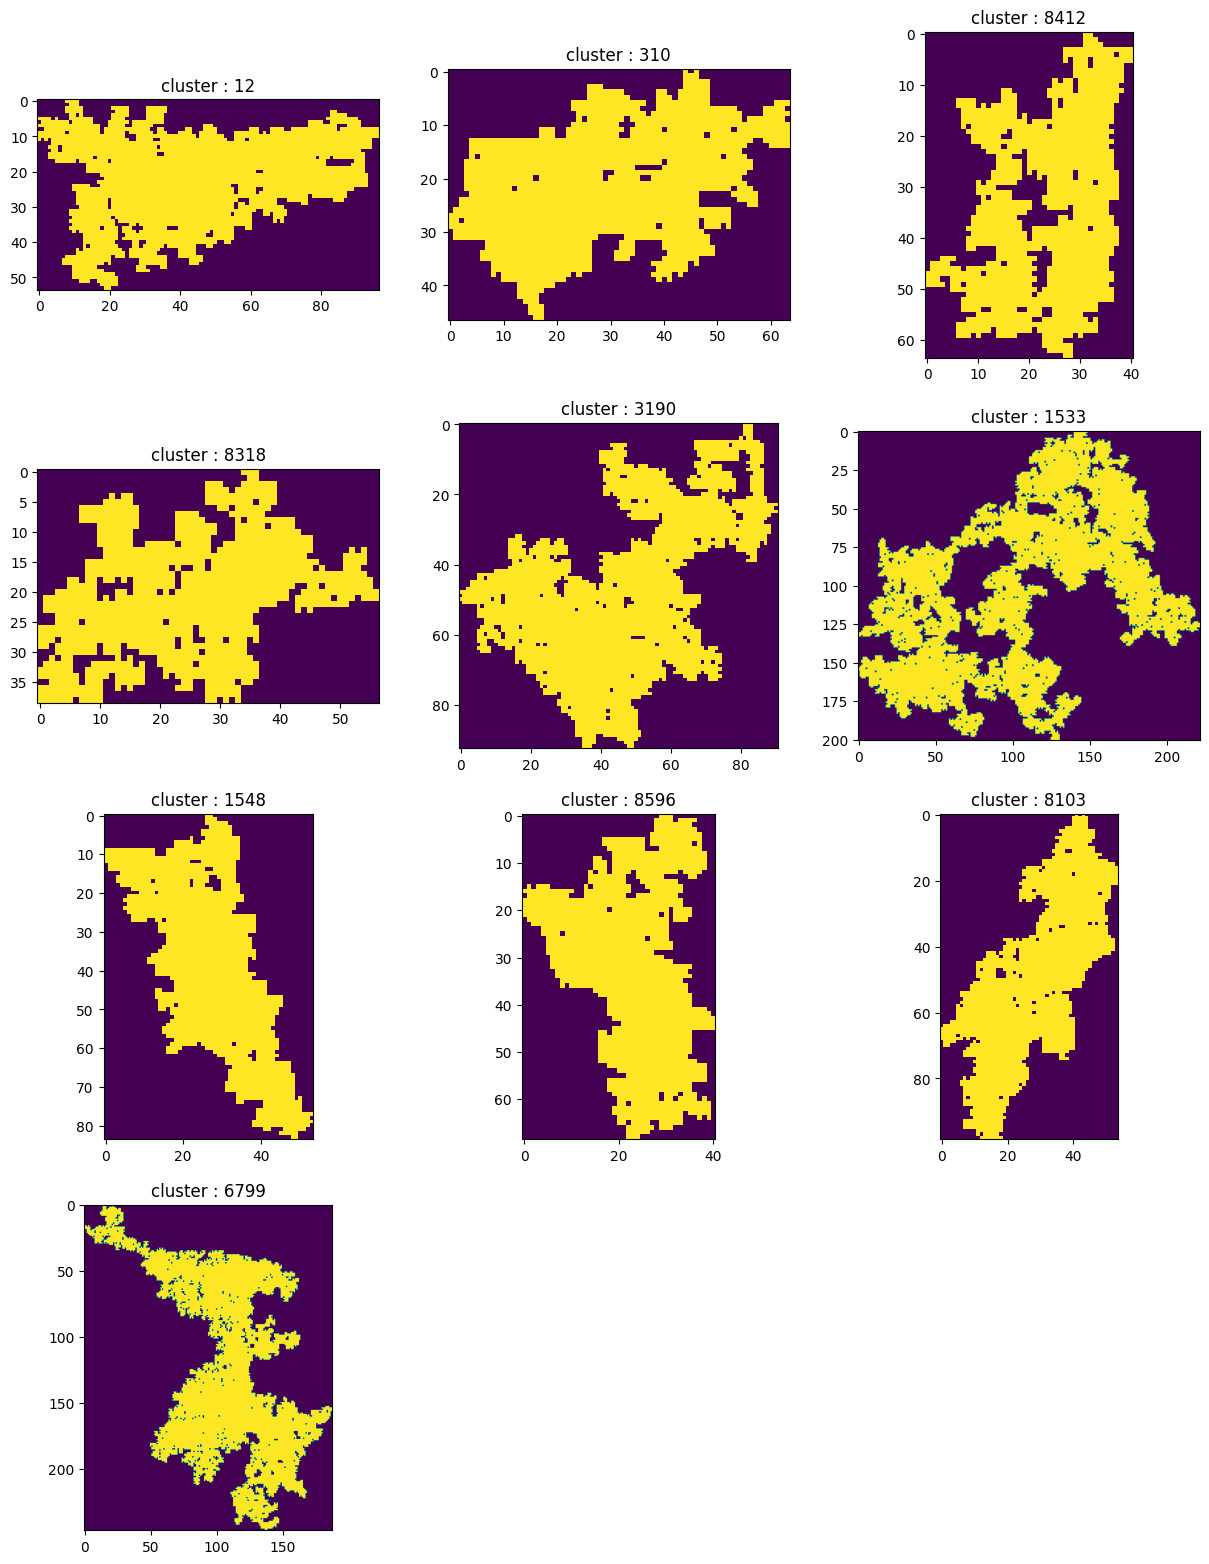

In [39]:
# idx = random.randint(0, len(list(feature_dict.keys()))-1)
input_segment = 12 #[1151, 1177, 1191]
n_segments = 10
# print('Segment number {} and its {}-closest segments in the database'.format(list(feature_dict.keys())[idx], n_segments-1))
# get_similar_items(feature_dict[list(feature_dict.keys())[idx]].flatten(), lsh, n_segments)
segments = plot_similar_items(
#     feature_dict[list(feature_dict.keys())[idx]].flatten(), 
    feature_dict[input_segment].flatten(),
    lsh, 
    pcd[noise_filter],
    labels[noise_filter],
    n_segments,
)

In [33]:
point_cloud_responses = pcd[noise_filter][np.isin(labels[noise_filter], segments)]
labels_responses = labels[noise_filter][np.isin(labels[noise_filter], segments)]
#Visualize n-closest segments from point cloud
pcd_o3d_responses = o3d.geometry.PointCloud()
pcd_o3d_responses.points = o3d.utility.Vector3dVector(point_cloud_responses[:,:3])

In [34]:
#plot in 3D the closest segments
# color with segmentation labels, random colors
max_label = labels_responses.max()
if max_label==-1:
    cmap = ListedColormap ( np.array([[0,0,0]]) )
elif -1 not in labels_responses:
    cmap = ListedColormap ( (np.random.rand( max_label+1, 3)) )
else:
    cmap = ListedColormap ( np.concatenate((np.array([[0,0,0]]), np.random.rand( max_label+1, 3)), axis=0))
colors = cmap(labels_responses+1)

colors = rgb2hsv(colors[:,:3])
colors[:,-1] = point_cloud_responses[:,3]
colors = hsv2rgb(colors[:,:3])

pcd_o3d_responses.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [35]:
o3d.visualization.draw_geometries([pcd_o3d_responses.random_down_sample(1), mesh_frame],)

In [36]:
pointCloudInterpretor.point_cloud[np.isin(labels, [2194])].shape

(17, 3)

### Write point cloud object to ASCII file to open it in other softwares

In [38]:
segment_ids = [2194, 1982, 32945]
write_pcd_to_ASCII(pointCloudInterpretor.point_cloud[np.isin(labels, segment_ids)], 
                   seis_ilBlock.cdp_x, seis_ilBlock.cdp_y, seis_ilBlock.twt, 
                   file_path='../outputs/my_geobody.txt')